# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [230]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [231]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [232]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [233]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


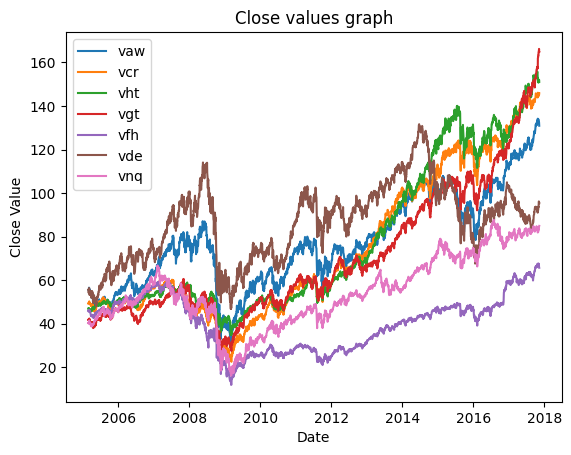

In [234]:
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vaw'], label='vaw')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vcr'], label='vcr')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vht'], label='vht')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vgt'], label='vgt')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vfh'], label='vfh')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vde'], label='vde')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values graph')
plt.legend()
plt.show()

In [235]:
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = data['Date']
data.pop('Date')
Train = data[:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

(2560, 35)
(641, 35)
641


In [236]:
import numpy as np

# Compute mean and std across samples and time steps for each feature
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1  # Prevent division by zero

# Normalize training data
#Train_normalized = Train
Train_normalized = (Train - mean) / std

# Normalize test data
# Assuming you have test data: X_test, Y_test
Test_normalized = (Test - mean) / std
#Test_normalized = Test

In [237]:
mode_list = ['multi', 'single']
ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']

In [238]:
mode = 'multi'
ETF_active = ETF[0];
fragment_size = 10;
step = 1

if (mode == mode_list[0]):
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, 1)]
  Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), 1)]
else:
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, 1)]
  Test_Labels = [Test.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), 1)]


In [239]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


Number of Train Fragments: 2550
Number of Train Labels: 2550
Number of Test Fragments: 631
Number of Test Labels: 631


In [240]:
import torch.nn as nn

class Simple_LSTM(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 output_size: int = 1,
                 num_layers: int = 5,
                 dropout_prob: float = 0.005,
                 activation_function=nn.Softmax(dim=1)):
        # Define RNN or LSTM architecture
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)

        self.activation_function = activation_function

        self.dropout = nn.Dropout(p=dropout_prob)
        self.batchnorm = nn.BatchNorm1d(hidden_size)

        self.last_linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        last_hidden_state = last_states[0][-1, :, :]
        # Applying dropout and batch normalization
        #last_hidden_state = self.dropout(last_hidden_state)
        #last_hidden_state = self.batchnorm(last_hidden_state)
        # Get sequence label probability using the last hidden state
        next_prediction = self.last_linear(last_hidden_state)
        return next_prediction


In [241]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output,Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [242]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [243]:
import matplotlib.pyplot as plt

# Example arrays for Y_predicted and Y
# Ensure these are defined as per your actual data
# Y_predicted = np.random.randn(640, 6)  # Example: If Y_predicted is a 2D array
# Y = np.random.randn(640, 6, 1)  # Example: If Y is a 3D array

def plot_results(Y_squeezed, Y_predicted, title = 'Test sample forecast of vaw'):
    # Check the shapes (for debugging purposes)
    print("Y_predicted shape:", Y_predicted.shape)
    print("Y shape after squeezing:", Y_squeezed.shape)

    # Plot the actual signals
    plt.figure(figsize=(12, 8))
    if Y_squeezed.ndim == 2:
      for i in range(1):#Y_squeezed.shape[1]):
          plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")
    else:
      plt.plot(Y_squeezed[:], label=f"Actual Signal {1}")

    # Ensure Y_predicted is compatible for plotting
    if Y_predicted.shape[1] == 1:
        # If Y_predicted is 1D, we plot it directly
        plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
    elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
        # If Y_predicted is 2D, plot each predicted signal
        for i in range(1):#Y_predicted.shape[1]):
            plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train, Y_train, X_test, Y_test are already defined and normalized
X_train_pt = X_train.float().to(device)
Y_train_pt = Y_train.float().to(device)
X_test_pt = X_test.float().to(device)
Y_test_pt = Y_test.float().to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_pt, Y_train_pt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25, shuffle=True)

print(X_train.shape)
print(Y_train.shape)

torch.Size([2550, 10, 35])
torch.Size([2550, 7])


In [245]:
# Training loop
def training_loop (num_epochs, loss_func):
  loss_its = []

  for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0.0

      # Iterate over batches in the DataLoader
      for batch_X, batch_Y in train_loader:
          optimizer.zero_grad()

          # Move batch data to the device
          batch_X = batch_X.to(device)
          batch_Y = batch_Y.to(device)

          # Forward pass
          output = model(batch_X)

          # Compute loss
          loss = loss_func(output, batch_Y)
          epoch_loss += loss.item()

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

      # Compute average loss for the epoch
      epoch_loss /= len(train_loader)
      loss_its.append(epoch_loss)

      # Print epoch statistics
      if epoch % 5 == 0:
          output_test = model(X_test_pt)
          test_loss = loss_func(output_test, Y_test_pt)
          print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')

  print('Training complete.')


In [246]:
if (mode == mode_list[0]):
  input_size = 35
  hidden_size = 2000
  num_layers = 1
  output_size = 7
  num_epochs = 50
else:
  input_size = 5
  hidden_size = 100
  num_layers = 1
  output_size = 1
  num_epochs = 4000

# Define model, loss function, and optimizer
model = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

training_loop(num_epochs, loss_func)


Epoch [0/50], Loss: 0.06208145637613009,Test_loss: 0.29994121193885803
Epoch [5/50], Loss: 0.0046835427250092225,Test_loss: 0.1720666140317917
Epoch [10/50], Loss: 0.004083694150561795,Test_loss: 0.10224592685699463
Epoch [15/50], Loss: 0.0037387631692028804,Test_loss: 0.12102805823087692
Epoch [20/50], Loss: 0.003595037408647876,Test_loss: 0.10751751065254211
Epoch [25/50], Loss: 0.003751351878129165,Test_loss: 0.08611764013767242
Epoch [30/50], Loss: 0.0032746803697983862,Test_loss: 0.1144525557756424
Epoch [35/50], Loss: 0.0029248065936068692,Test_loss: 0.10458800196647644
Epoch [40/50], Loss: 0.002418783117843536,Test_loss: 0.10347157716751099
Epoch [45/50], Loss: 0.002189139430365507,Test_loss: 0.08014069497585297
Training complete.


# Histogram

In [247]:
#Print Train
Y_predicted_train = model(X_train_pt).cpu().detach().numpy()
print(Y_predicted_train)

if (mode == mode_list[0]):
  Y_train = Train_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  Y = Train_normalized[fragment_size:][['Close_'  + ETF_active]]
Y_train = Y_train.to_numpy()

#Print Test
Y_predicted_test = model(X_test_pt).cpu().detach().numpy()
print(Y_predicted_test)

if (mode == mode_list[0]):
  Y_test = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  Y_test = Test_normalized[fragment_size:][['Close_'  + ETF_active]]
Y_test = Y_test.to_numpy()

[[-0.9432128  -0.52975076 -0.987262   ... -1.7389461  -0.7351862
  -0.65521526]
 [-0.9329944  -0.53875333 -1.0083214  ... -1.698633   -0.754112
  -0.68795395]
 [-0.9233777  -0.52569795 -1.0061326  ... -1.7008744  -0.7472738
  -0.6440569 ]
 ...
 [ 2.0959356   2.6964898   2.7513933  ...  1.1833174   3.2061214
   2.1050303 ]
 [ 2.1099737   2.6495028   2.7144766  ...  1.1884453   3.1178246
   2.0911107 ]
 [ 2.118878    2.6169252   2.7093036  ...  1.2008895   3.085095
   2.0253139 ]]
[[2.110164   2.6207702  2.701057   ... 1.0846996  3.1094825  1.9454974 ]
 [2.1502774  2.649907   2.7462788  ... 1.0642006  3.1456988  1.9707811 ]
 [2.174894   2.6808574  2.7726548  ... 1.0829284  3.184796   2.0341017 ]
 ...
 [3.3900542  3.907519   4.591619   ... 0.6989795  4.273059   2.5741997 ]
 [3.3835773  3.9034815  4.615921   ... 0.64209366 4.250507   2.5505948 ]
 [3.3170068  3.8483298  4.4670715  ... 0.70649385 4.196529   2.5807655 ]]


Y_predicted shape: (2550, 7)
Y shape after squeezing: (2550, 7)


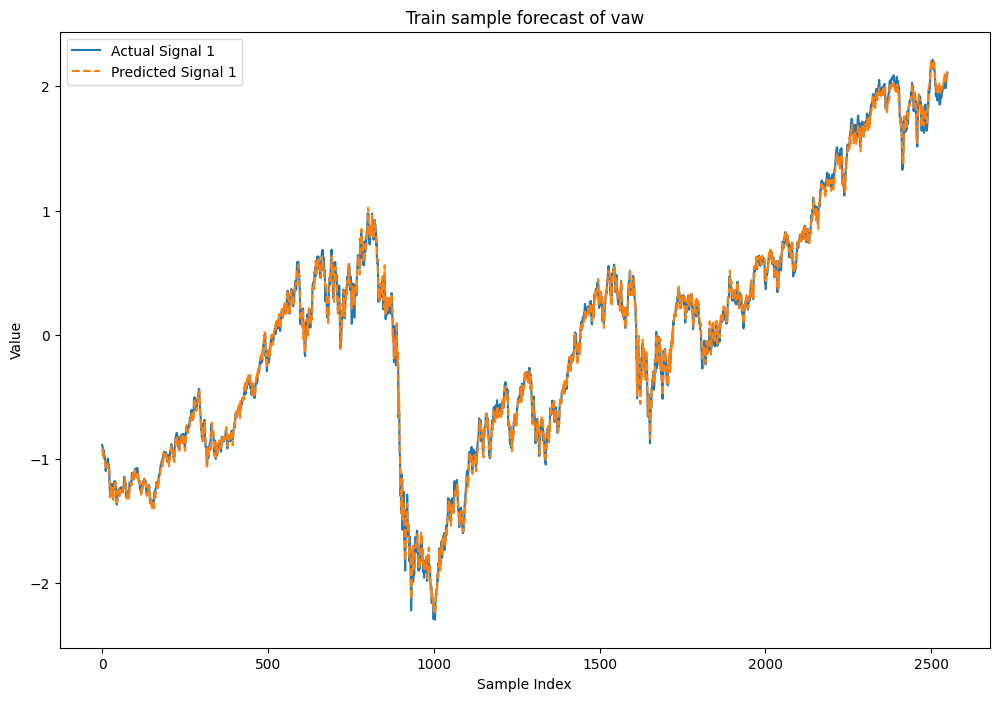

In [248]:

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_train.squeeze()
Y_predicted = Y_predicted_train
plot_results(Y_squeezed, Y_predicted, 'Train sample forecast of vaw')

Y_predicted shape: (631, 7)
Y shape after squeezing: (631, 7)


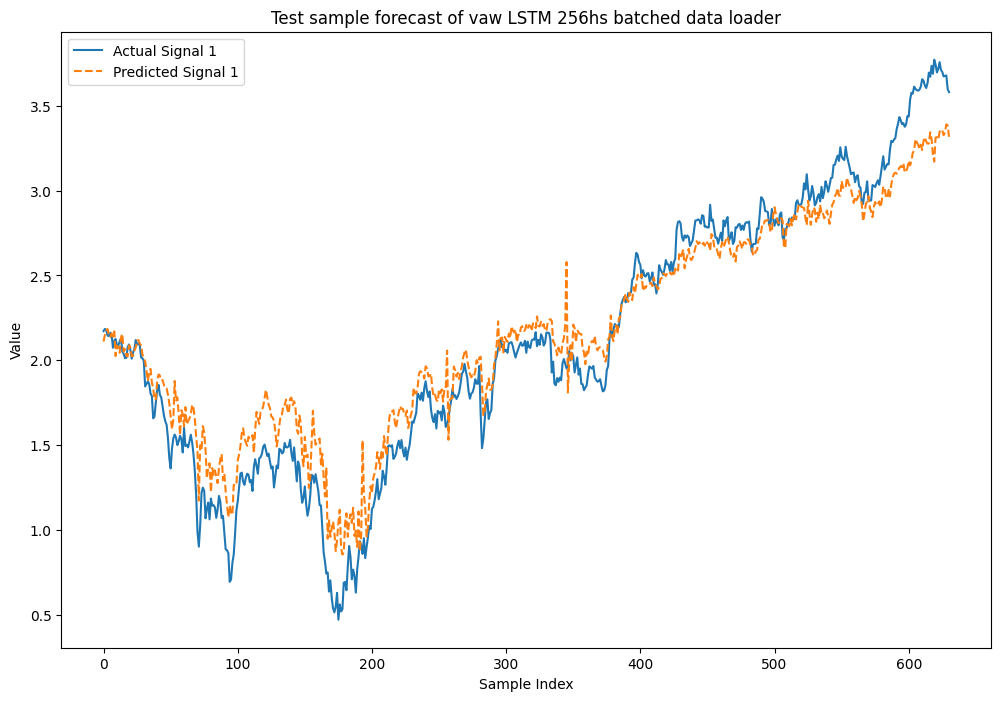

In [249]:
# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_test.squeeze()
Y_predicted = Y_predicted_test
plot_results(Y_squeezed, Y_predicted, 'Test sample forecast of vaw LSTM 256hs batched data loader')

[[2.110164   2.6207702  2.701057   ... 1.0846996  3.1094825  1.9454974 ]
 [2.1502774  2.649907   2.7462788  ... 1.0642006  3.1456988  1.9707811 ]
 [2.174894   2.6808574  2.7726548  ... 1.0829284  3.184796   2.0341017 ]
 ...
 [3.3900542  3.907519   4.591619   ... 0.6989795  4.273059   2.5741997 ]
 [3.3835773  3.9034815  4.615921   ... 0.64209366 4.250507   2.5505948 ]
 [3.3170068  3.8483298  4.4670715  ... 0.70649385 4.196529   2.5807655 ]]


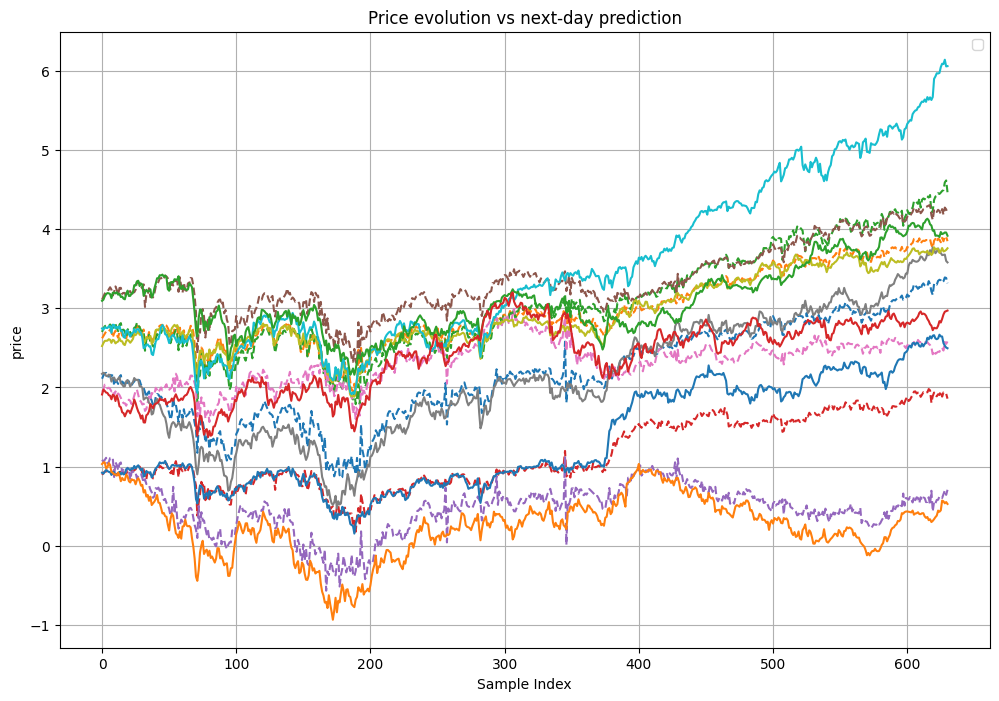

In [250]:
Y_predicted = model(X_test_pt).cpu().detach().numpy()
Y = Y_test_pt.cpu().detach().numpy()
print(Y_predicted)

plt.figure(figsize=(12, 8))
plt.plot(Y_predicted,linestyle='--',)
plt.plot(Y)
plt.title('Price evolution vs next-day prediction')
plt.xlabel('Sample Index')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.show()

In [251]:
!pip install scipy

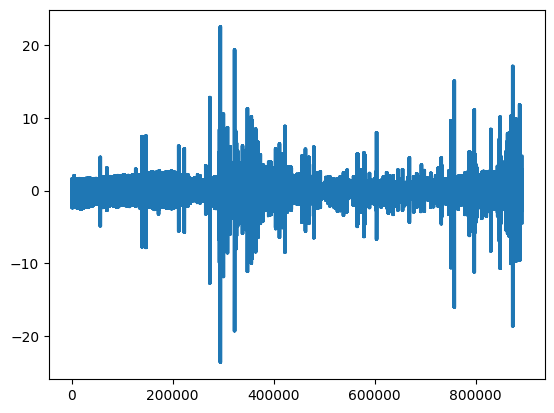

In [254]:
from statsmodels.tsa.stattools import acf, pacf
import scipy.ndimage
from statsmodels.tsa.arima.model import ARIMA
n_diff = 2
train_x_diff = X_train.flatten() - scipy.ndimage.shift(X_train.flatten(), n_diff, cval=np.nan)
train_x_diff = train_x_diff[n_diff: ]
plt.plot(train_x_diff)

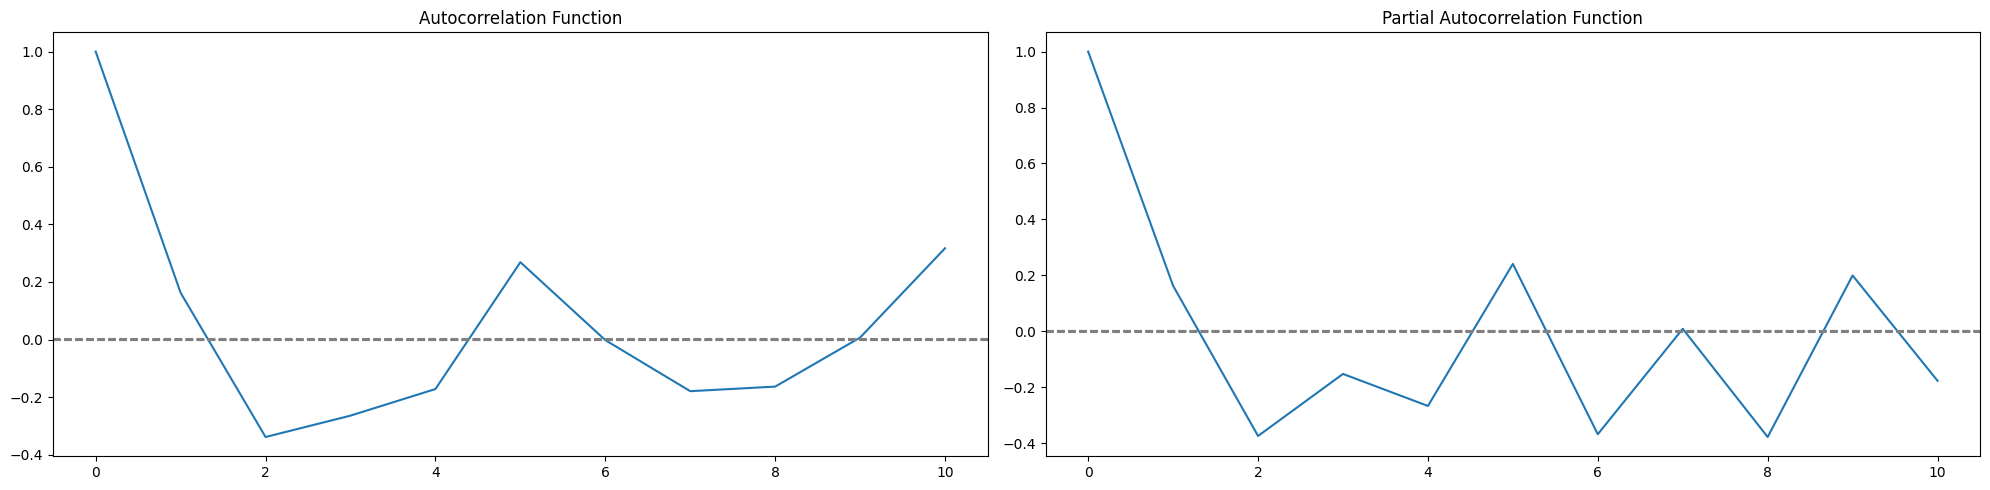

In [255]:
lag_acf = acf(train_x_diff, nlags=10)
lag_pacf = pacf(train_x_diff, nlags=10, method='ols')
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(X_train.flatten() )),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(X_train.flatten() )),linestyle='--',color='gray')
plt.title('Autocorrelation Function')#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(X_train.flatten() )),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(X_train.flatten() )),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

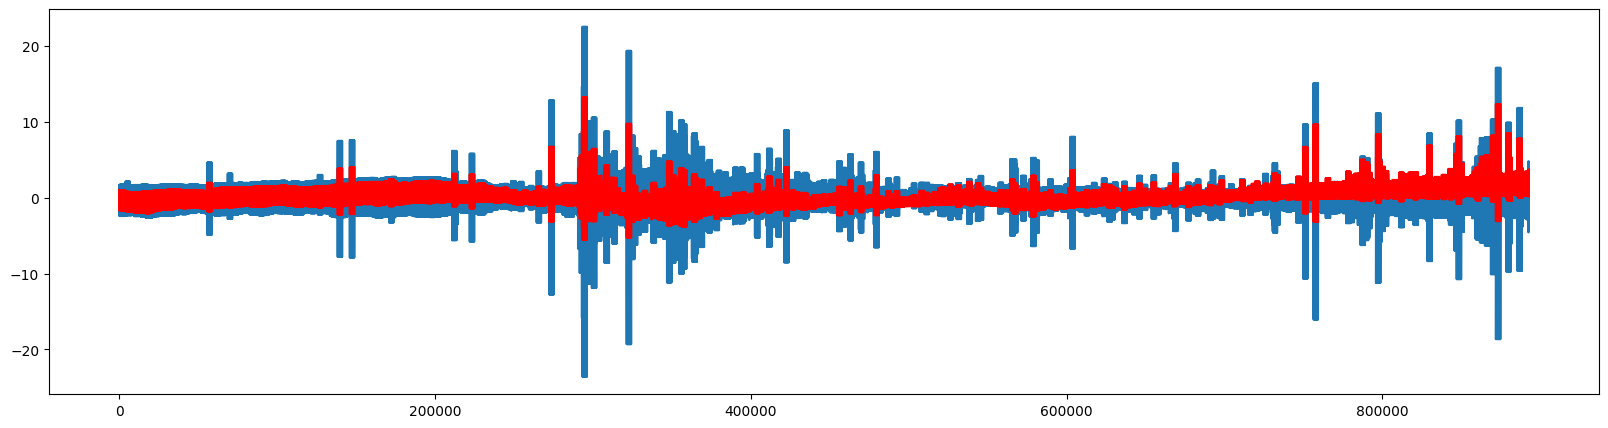

In [257]:
X_train_np = X_train.numpy()
model = ARIMA(X_train_np.flatten(), order=(2, 2, 2))
results_AR = model.fit()
plt.figure(figsize=(20,5))
plt.plot(train_x_diff)
plt.plot(results_AR.fittedvalues, color='red')

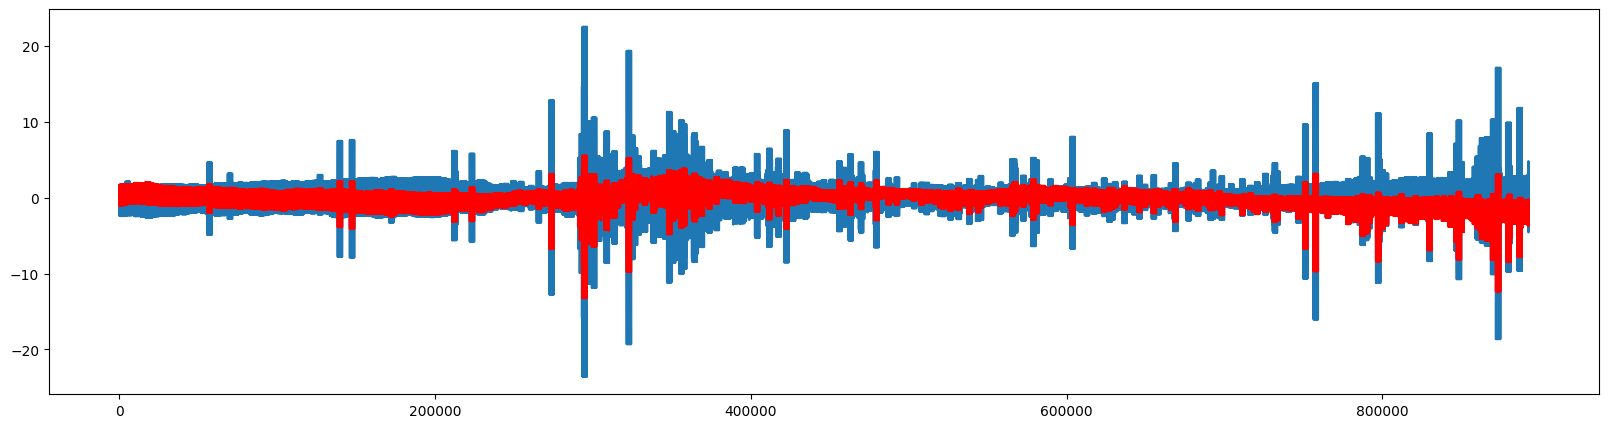

In [258]:
plt.figure(figsize=(20,5))
plt.plot(train_x_diff)
plt.plot(-1*results_AR.fittedvalues, color='red')

In [261]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.ndimage import shift
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Example data, replace these with your actual data
# X_train = ...
# test_y = ...
n_diff = 2

# Fit ARIMA model (assuming this is done prior)
# results_AR = ARIMA(...).fit()

# Predict with the ARIMA model
y_pred = results_AR.predict(start=398, end=597)

# Adjust y_pred using a loop and shift function
y_pred = -1 * y_pred

# Assuming test_y is a 2D array and we're using the first element in the second dimension
for i in range(2, 200):
    y_pred[i] = y_pred[i] + test_y[i-2][0]

# If needed, you can use shift to preprocess your training data
train_x_diff = X_train.flatten() - shift(X_train.flatten(), n_diff, cval=np.nan)

# Make sure to handle any NaN values that may result from the shift operation
train_x_diff = np.nan_to_num(train_x_diff)

# Now, train_x_diff is ready for further processing


NameError: name 'test_y' is not defined